<a href="https://colab.research.google.com/github/cosmina98/PhD/blob/main/Sep/GGNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install plotnine --quiet
!pip install torch_geometric  --quiet
!pip install torch_geometric  --quiet
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html --quiet
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html  --quiet
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git   --quiet


1.12.1+cu113
     |████████████████████████████████| 467 kB 5.3 MB/s 
     |████████████████████████████████| 7.9 MB 4.4 MB/s 
     |████████████████████████████████| 3.5 MB 4.6 MB/s 


In [2]:
import torch
import torch.nn.functional as F
from torch.optim import Optimizer
from torch import Tensor
from torch import nn
from torch.optim.sgd import SGD
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv,ChebConv
from torch_geometric.utils import get_laplacian
from torch_geometric.utils import to_scipy_sparse_matrix
from torch_geometric.nn import GatedGraphConv
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import uniform
from torch.optim.adam import Adam

import os.path as osp


from typing import Callable, List, Optional, Tuple
from typing_extensions import Literal, TypedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from tqdm.notebook import trange, tqdm
import copy
import random
import time
import  math
import itertools
from functools import reduce
import operator
import torch.utils.data as data_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from torch.utils.data import Subset
from plotnine import ggplot, geom_line, aes, xlab, theme, element_blank, ggtitle
from collections import OrderedDict
from typing_extensions import Literal, TypedDict
from torch_sparse import SparseTensor
from torch_scatter import gather_csr, scatter, segment_csr
from torch.nn import Parameter as Param
from torch.nn import Parameter, Module
import inspect

from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')



#Dataset imports

In [12]:
dataset=list(range(3))
i=0
for dataset_name in ['Cora','CiteSeer','PubMed']:
    dataset[i] = Planetoid('/tmp/dataset_name', name=dataset_name,transform=T.NormalizeFeatures())
    num_nodes = dataset[i].data.num_nodes
    num_edges = dataset[i].data.num_edges // 2
    train_len = dataset[i][0].train_mask.sum()
    val_len = dataset[i][0].val_mask.sum()
    test_len = dataset[i][0].test_mask.sum()
    other_len = num_nodes - train_len - val_len - test_len
    print(f"Dataset: {dataset[i].name}")
    print(f"Num. nodes: {num_nodes} (train={train_len}, val={val_len}, test={test_len}, other={other_len})")
    print(f"Num. edges: {num_edges}")
    print(f"Num. node features: {dataset[i].num_node_features}")
    print(f"Num. classes: {dataset[i].num_classes}")
    print(f"Dataset len.: {dataset[i].len()}")
    i=i+1
    print(" ")

Dataset: Cora
Num. nodes: 2708 (train=140, val=500, test=1000, other=1068)
Num. edges: 5278
Num. node features: 1433
Num. classes: 7
Dataset len.: 1
 
Dataset: CiteSeer
Num. nodes: 3327 (train=120, val=500, test=1000, other=1707)
Num. edges: 4552
Num. node features: 3703
Num. classes: 6
Dataset len.: 1
 
Dataset: PubMed
Num. nodes: 19717 (train=60, val=500, test=1000, other=18157)
Num. edges: 44324
Num. node features: 500
Num. classes: 3
Dataset len.: 1
 


##Training and testing targets for each dataset


In [4]:

d={0:{}, 1:{}, 2:{}}
for i in range(3):
    data=dataset[i]
    X_train=data[0].x[data[0].train_mask]
    d[i]['X_train']=X_train
    y_train=data[0].y[data[0].train_mask]
    d[i]['y_train']=y_train
    X_test=data[0].x[data[0].test_mask]
    d[i]['X_test']=X_test
    y_test=data[0].y[data[0].test_mask]
    d[i]['y_test']=y_test
    X_val=data[0].x[data[0].val_mask]
    d[i]['X_val']=X_val
    y_val=data[0].y[data[0].val_mask]
    d[i]['y_val']=X_val

#The model

In [5]:
class GatedGraphConv(MessagePassing):
    
    def __init__(self, out_channels, num_layers, aggr = 'add',
                 bias = True, **kwargs):
        super(GatedGraphConv, self).__init__(aggr=aggr, **kwargs)

        self.out_channels = out_channels
        self.num_layers = num_layers

        self.weight = Param(Tensor(num_layers, out_channels, out_channels))
        self.rnn = torch.nn.GRUCell(out_channels, out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        uniform(self.out_channels, self.weight)
        self.rnn.reset_parameters()

    def forward(self, data):
        """"""
        x = data.x
        edge_index = data.edge_index
        edge_weight = data.edge_attr
        if x.size(-1) > self.out_channels:
            raise ValueError('The number of input channels is not allowed to '
                             'be larger than the number of output channels')

        if x.size(-1) < self.out_channels:
            zero = x.new_zeros(x.size(0), self.out_channels - x.size(-1))
            x = torch.cat([x, zero], dim=1)

        for i in range(self.num_layers):
            m = torch.matmul(x, self.weight[i])
            m = self.propagate(edge_index, x=m, edge_weight=edge_weight,
                               size=None)
            x = self.rnn(m, x)

        return x

    def message(self, x_j, edge_weight):
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t, x):
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self):
        return '{}({}, num_layers={})'.format(self.__class__.__name__,
                                              self.out_channels,
                                              self.num_layers)


In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dims, out_dim):
        super(MLP, self).__init__()

        self.mlp = nn.Sequential()
        dims = [input_dim] + hid_dims + [out_dim]
        for i in range(len(dims)-1):
            self.mlp.add_module('lay_{}'.format(i),nn.Linear(in_features=dims[i], out_features=dims[i+1]))
            if i+2 < len(dims):
                self.mlp.add_module('act_{}'.format(i), nn.Tanh())
    def reset_parameters(self):
        for i, l in enumerate(self.mlp):
            if type(l) == nn.Linear:
                nn.init.xavier_normal_(l.weight)

    def forward(self, x):
        return self.mlp(x)



In [7]:
class GGNN(torch.nn.Module):
    def __init__(self,num_classes,data):
        self.num_classes=num_classes
        self.data=data
        super(GGNN, self).__init__()
        
        self.conv = GatedGraphConv( len(self.data.x[1]) , 3)
        self.mlp = MLP( len(self.data.x[1]), [32,32,32], self.num_classes)
        
    def forward(self):
        x = self.conv(data)
        x = self.mlp(x)
        return F.log_softmax(x, dim=-1)

In [8]:
data = dataset[0][0]
data.x[1]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [9]:
dataset = 'Cora'
path = osp.join('data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]
data = data.to(device)

Processing...
Done!


In [10]:
len(dataset[1][0].x[1])

IndexError: ignored

In [14]:


LossFn= Callable[[Tensor, Tensor], Tensor]
def train_step(model, data, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    mask=data.train_mask
    logits=model()[mask]
    preds=logits.argmax(dim=1)
    loss=loss_fn(logits, data.y[mask])
    acc=accuracy_score(preds,  data.y[mask])
    loss.backward()
    optimizer.step()
    return loss.item(), acc

def eval_step(model, data, loss_fn):
    model.eval()
    logits, accs,losses = model(), [],[]
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
        loss=loss_fn(logits[mask], data.y[mask])
        losses.append(loss.item())
    return losses, accs

  

In [15]:
class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]

def train(
    model: torch.nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    loss_fn: LossFn = torch.nn.CrossEntropyLoss(),
    max_epochs: int = 200,
    early_stopping: int = 10,
    print_interval: int = 20,
    verbose: bool = False,
) -> HistoryDict:
    history = {"loss": [], "val_loss": [], "acc": [], "val_acc": [],"test_acc":[],"test_loss":[]}
    for epoch in range(max_epochs):
        train_step(model, data, optimizer, loss_fn)
        loss, acc = eval_step(model, data, loss_fn)
        history["loss"].append(loss[0])
        history["acc"].append(acc[0])
        history["val_loss"].append(loss[1])
        history["val_acc"].append(acc[1])
        history["test_loss"].append(loss[2])
        history["test_acc"].append(acc[2])
        # The official implementation in TensorFlow is a little different from what is described in the paper...
        if epoch > early_stopping and loss[1] > np.mean(history["val_loss"][-(early_stopping + 1) : -1]):
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and print_interval:
            print('Epoch: {:03d}, Train Acc: {:.5f}, '
          'Val Acc: {:.5f}, Test Acc: {:.5f}'.format(epoch, acc[0],
                                                       acc[1], acc[2]))


    
    return history
def plot_history(history: HistoryDict, title: str, font_size: Optional[int] = 14) -> None:
    plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()

In [16]:
SEED = 42
MAX_EPOCHS = 200
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
EARLY_STOPPING = 10
torch.manual_seed(SEED)
device = "cpu"

data = dataset[0][0]
model = GGNN(dataset[0].num_classes, data).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
history = train(model, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)


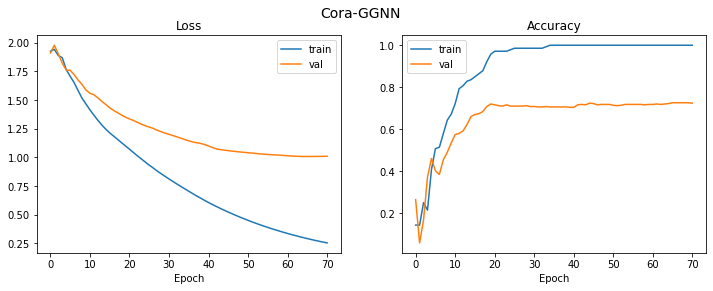

In [17]:
plt.figure(figsize=(12, 4))
plot_history(history, "Cora-GGNN")

In [18]:
data = dataset[1][0]
model = GGNN(dataset[1].num_classes,data).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
history2 = train(model, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

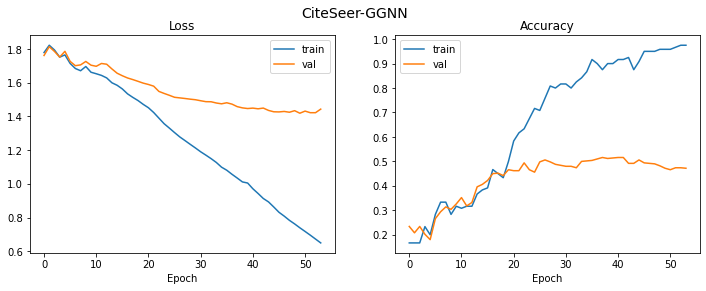

In [19]:
plt.figure(figsize=(12, 4))
plot_history(history2, "CiteSeer-GGNN")

In [21]:
data = dataset[2][0]
model = GGNN(dataset[2].num_classes,data).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
history3 = train(model, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

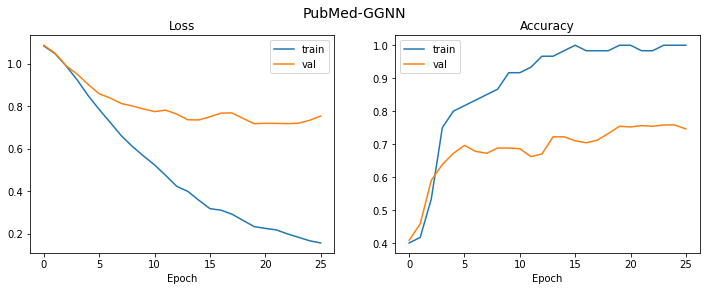

In [22]:
plt.figure(figsize=(12, 4))
plot_history(history3, "PubMed-GGNN")